In [1]:
from fastai.basics import *
from fastai.gen_doc.nbdoc import *

In [2]:
import fastai
from fastai.version import __version__
print(__version__)

1.0.61


## Text

Next application is text, so let's start by importing everything we'll need.

In [3]:
from fastai.text import *

### Language modelling

First we'll fine-tune a pretrained language model on our subset of imdb.

In [4]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [5]:
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .split_by_rand_pct()
                   .label_for_lm()  # Language model does not need labels
                   .databunch())
data_lm.save()

`data.show_batch()` will work here as well. For a language model, it shows us the beginning of each sequence of text along the batch dimension (the target being to guess the next word).

In [6]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk ! xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is"
1,"nice , creepy xxmaj spanish castle and good xxunk , i found it to be fairly boring and predictable , with no excitement or mystery , whatsoever . \n \n 3 out of 10 . xxbos i have always liked xxmaj spike xxmaj lee 's movies , but this one was a total waste of 2 1 / 2 hours . i expected more about xxmaj son of xxmaj"
2,"and / or a xxunk logic , all his attempts go awry , much to the delight of the viewer . \n \n xxmaj xxunk xxmaj goldberg plays xxmaj rose xxmaj xxunk , the show 's chief writer and xxmaj celeste 's xxunk - ego and xxunk while xxmaj xxunk xxmaj fisher has a xxunk part as the hard - as - xxunk producer of the show . \n"
3,"for others . xxmaj xxunk . xxmaj god , bless "" xxmaj xxunk it like xxmaj xxunk "" i believe it is a true gem . xxbos xxmaj the fact that most of the budget for this presumably went on the heavy - duty cast list should n't have xxunk if it had been staged with flair and imagination and some sympathy for the original 's satirical intent . xxmaj"
4,"is that bad ? xxmaj not really . xxmaj everyone needs a feeling of belonging . xxmaj but like the school paper of one of the schools i xxunk once wrote about that , "" we should all try to hang around with students of other xxunk and try to know them . "" xxmaj otherwise you 're creating your own xxunk . \n \n xxmaj racism certainly xxunk"


In [7]:
# Special tokens
# xxbos: Begining of a sentence
# xxfld: Represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2).
# xxup: If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“
# xxunk: token used instead of an uncommon word.
# xxmaj: token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.
# xxrep: token indicates repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !).

In [8]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

#### Numericalization
Finally it is easier for machine to deal with the numbers so replace the tokens with the location of the token in the vocab:

In [9]:
data_lm.train_ds[0][0].data[:10]

array([  2,   5,   0,  26,   0,  26, 909,  53,   5,   0])

The default vocab size is set to 60,000 words and min count for a word to be added to vocab is 2, to avoid getting the weight matrix huge.

Now let's define a language model learner. drop_mult - a hyper-parameter ,used for regularization, sets the amount of dropout. If the model is over-fitting increase it, if under-fitting, you can decrease the number.

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM)
learn.fit_one_cycle(4, 1e-2)
learn.save('mini_train_lm')
learn.save_encoder('mini_train_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,4.390880,3.751441,0.295061,00:19
1,4.139402,3.702072,0.296819,00:19
2,3.924169,3.692961,0.297307,00:20
3,3.773365,3.689845,0.297838,00:20


Then we can have a look at the results. It shows a certain amount of words (default 20), then the next 20 target words and the ones that were predicted.

In [11]:
learn.show_results()

text,target,pred
"xxbos xxmaj as a matter of fact , this is one of those movies you would have to give xxunk","to . xxmaj the fact is ; as already stated , it 's a great deal of fun . xxmaj","to . xxmaj the movie that that the the , , the 's a xxunk film . xxunk . xxmaj"
. xxmaj the main point of conflict between the two leads does n't play out in a realistic manner at,"all . xxmaj there are a few scenes where they disagree because of it , but no xxunk of any",all . xxmaj the are no few scenes that the are with they the . but they one . the
"xxmaj xxunk 's loud , screaming happy kids and xxmaj rose and xxmaj xxunk enjoying every minute of it .","xxbos xxmaj everyday we can watch a great number of film , soap ... on tv . xxmaj sometimes a","xxmaj xxmaj the , are see this movie movie of movies - and opera and the , xxmaj the the"
"'ve liked "" xxmaj la xxmaj xxunk xxmaj xxunk ... "" check out also "" xxmaj la xxmaj xxunk che","xxmaj evelyn xxunk xxunk xxmaj xxunk "" . xxbos xxup dvd has become the xxunk of the old late night",""" xxunk "" "" "" xxunk "" ) ) xxmaj xxunk xxmaj a a basis of the xxmaj xxmaj -"
other xxunk movie xxmaj xxunk xxmaj plan . \n \n xxmaj here is my xxmaj xxunk xxmaj plan comment,: xxunk : / / xxunk / title / xxunk / xxunk \n \n i recommend . xxmaj not,xxmaj xxmaj xxmaj xxmaj / xxunk / xxunk / xxunk / xxmaj 'm this xxmaj the only much . xxunk


In [12]:
learn.predict('When I saw this movie the second time', 100)


'When I saw this movie the second time , only i aware 6 of the anyone wanting them . i \'d get such a comment from Fred Astaire , the Ann Washington : i was not expecting a review by Fred Astaire or causes sadly to watch like wanting to make them feel like people . \n \n  Fred Astaire was originally one of the worst actors to ever fffc . Dressed to Kill was a 17 year in criminal code . \n \n  Notable detective story survivors used in the plot included " Photographer Harris "'

In [13]:
learn.predict('As I was going up the stair I met a man who wasn\'t there.', 100)

"As I was going up the stair I met a man who wasn't there. He was a strong reporter . He was very intelligence and thoroughly watchable . The police were telling me and who of course was always a teacher . He ... my guy , he somewhere got my money ! He was more useful as a RELIEF man . Sell of this girl at the am we should be asking anymore . He would pass his basic class for his first grade . It wo not matter if he gets there . At his best , he was the opposite of"

Learning rate hyper-parameter is one of the most important parameters to train a model. Fast.ai provides a convenient utility (learn.lr_find) to search through a range of learning rates to find the optimum one for our dataset. Learning rate finder will increase the learning rate after each mini-batch. Eventually, the learning rate is too high that loss will get worse. Now look at the plot of learning rate against loss and determine the lowest point (around 1e-1 for the plot below) and go back by one magnitude and choose that as a learning rate (something around 1e-2).

### Classification

Now let's see a classification example. We have to use the same vocabulary as for the language model if we want to be able to use the encoder we saved.

In [14]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text', vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch(bs=42))

Here show_batch shows the beginning of each review with its target.

In [15]:
data_clas.show_batch()

text,target
"xxbos xxmaj xxunk xxmaj victor xxmaj xxunk : a xxmaj review \n \n xxmaj you know , xxmaj xxunk xxmaj victor xxmaj xxunk is like sticking your hands into a big , xxunk xxunk of xxunk . xxmaj it 's warm and xxunk , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and xxunk xxmaj xxunk xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


And we can train a classifier that uses our previous encoder.

In [16]:
learn_cl = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_cl.load_encoder('mini_train_encoder')
learn_cl.fit_one_cycle(6, slice(1e-3,1e-2))
learn_cl.save('mini_train_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.644936,0.627262,0.595000,00:16
1,0.545071,0.538481,0.770000,00:17
2,0.506082,0.533946,0.725000,00:16
3,0.470617,0.484739,0.765000,00:15
4,0.443588,0.474292,0.760000,00:16
5,0.413393,0.475649,0.750000,00:16


**Momentum**  
There is one more argument(moms=(0.8,0.7))﹣momentums equals 0.8,0.7. Basically for training recurrent neural networks (RNNs), it really helps to decrease the momentum a little bit.The right side above is the momentum plot. Every time our learning rate is small, our momentum is high. Why is that? Because as you are learning small learning rate, but you keep going in the same direction, you may as well go faster (higher momentum). But as you are learning high learning rate, but you keep going in the same direction, you may overshoot the target, so momentum should be slowed. This trick can help you train 10 times faster.

In [17]:
learn_cl.fit_one_cycle(2, slice(1e-3,1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.385223,0.599715,0.725000,00:15
1,0.395529,0.494499,0.740000,00:16


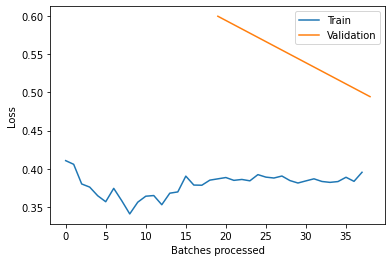

In [18]:
learn_cl.recorder.plot_losses()

In [19]:
learn_cl.show_results()

text,target,prediction
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive,positive
"xxbos xxmaj to review this movie , i without any doubt would have to xxunk that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative,negative
"xxbos xxmaj how viewers react to this new "" adaption "" of xxmaj shirley xxmaj jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one",negative,negative
"xxbos xxmaj the trouble with the book , "" xxmaj memoirs of a xxmaj geisha "" is that it had xxmaj japanese xxunk but underneath the xxunk it was all an xxmaj american man 's way of thinking . xxmaj reading the book is like watching a magnificent ballet with great music , sets , and costumes yet performed by xxunk animals dressed in those xxunk far from xxmaj japanese",negative,negative
"xxbos xxmaj xxunk had a great cast of wonderful actors . xxmaj xxunk xxmaj xxunk , xxmaj xxunk xxmaj xxunk , xxmaj michael xxmaj xxunk , xxmaj dan xxmaj xxunk , and even xxmaj guy xxmaj williams ( as the cousin who was brought in for several episodes during 1964 to xxunk xxmaj xxunk when he was leaving the series ) . xxmaj the cast had chemistry , and they",positive,negative


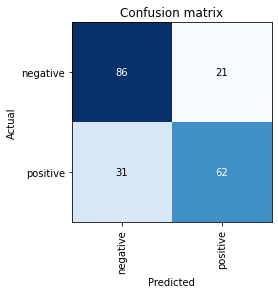

In [20]:
preds, y, losses = learn_cl.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_cl, preds, y, losses)
interp.plot_confusion_matrix()

### Excercise
Make sentiment predictions for 5 movie reviews from IMDB web site.

In [21]:
# A rotten tomatos review for Christopher's Nolan movie Inception
first_movie_review = learn.predict('This endlessly fascinating swirl ', 58)
first_movie_review

"This endlessly fascinating swirl  is a classic film in the genre , although ironically one of the greatest films ever made . But they 're still one of the greatest films ever made to say they had it . \n \n  It is this film that makes a unique film about a young man who struggles to want to live in"

In [22]:
real_first_movie_review = print('This endlessly fascinating swirl of a film could have come only from Nolan, who blends the cerebral twistiness of Memento (his thriller that moves backward in time) with the spectacular action of his Batman megahit, The Dark Knight')

This endlessly fascinating swirl of a film could have come only from Nolan, who blends the cerebral twistiness of Memento (his thriller that moves backward in time) with the spectacular action of his Batman megahit, The Dark Knight


In [23]:
first_movie_review_classifier = learn_cl.predict(first_movie_review)
print(first_movie_review_classifier[2][0])

tensor(0.0261)


In [24]:
# A quote from The Usual Suspects 
# should have 14 words
second_movie_quote= learn.predict('The greatest trick the Devil ever pulled', 9)
second_movie_quote

'The greatest trick the Devil ever pulled came in 2001 once Ms. Greenstreet did'

In [25]:
real_second_quote = print("The greatest trick the Devil ever pulled was convincing the world he didn't exist")

The greatest trick the Devil ever pulled was convincing the world he didn't exist


In [26]:
second_movie_review_classifier = learn_cl.predict(second_movie_quote)
print(second_movie_review_classifier[2][0])

tensor(0.1274)


In [27]:
# A quote from V for Vendetta
# should have 24 words 
third_movie_quote = learn.predict('Remember, remember, the fifth,',20)
third_movie_quote

'Remember, remember, the fifth, i was who crying -- with a different accent PAT than in **** !!!! You know'

In [28]:
real_third_movie_review = print('"Remember, remember, the Fifth of November, the Gunpowder Treason and Plot. I know of no reason why the Gunpowder Treason should ever be forgot..."')

"Remember, remember, the Fifth of November, the Gunpowder Treason and Plot. I know of no reason why the Gunpowder Treason should ever be forgot..."


In [29]:
third_movie_review_classifier = learn_cl.predict(third_movie_quote)
print(third_movie_review_classifier[2][0])

tensor(0.3985)


In [30]:
fourth_movie_review = learn.predict('Nolan masterfully weaves', 28)
fourth_movie_review


'Nolan masterfully weaves the serious intent of Hitchcock , including the Book , the " Cause Horror " movie . There are notes , including the'

In [31]:
fourth_movie_review_classifier = learn_cl.predict(fourth_movie_review)
print(fourth_movie_review_classifier[2][0])

tensor(0.1184)


In [32]:
real_fourth_review = print('Nolan masterfully weaves all these elements together, creating a second act that is breathtaking, suspenseful and thought-provoking...unfortunately, it takes us a good hour for us to get there.')

Nolan masterfully weaves all these elements together, creating a second act that is breathtaking, suspenseful and thought-provoking...unfortunately, it takes us a good hour for us to get there.


In [33]:
fifth_movie_review = learn.predict('Infused with',27)
fifth_movie_review


'Infused with only 50 % achievement in houses , Gun City has a low impact / scale Thus far , land quality fine with many terrain'

In [34]:
real_fifth_movie_review = print('Infused with his trademark wit, the film is hilarious at times but also carries with it more complex undertones. Benjamin is a gorgeous little film.')

Infused with his trademark wit, the film is hilarious at times but also carries with it more complex undertones. Benjamin is a gorgeous little film.


In [35]:
fifth_movie_review_classifier = learn_cl.predict(fifth_movie_review)
print(fifth_movie_review_classifier[2][0])

tensor(0.8065)


In [42]:
learn_cl.data.classes

['negative', 'positive']

In [38]:
first = ("""What is the most resilient parasite? An Idea! Yes, Nolan has created something with his unbelievably, incredibly and god- gifted mind which will blow the minds of the audience away. The world premiere of the movie, directed by Hollywood's most inventive dreamers, was shown in London and has already got top notch reviews worldwide and has scored maximum points! Now the question arises what the movie has that it deserve all this?

Dom Cobb(Di Caprio) is an extractor who is paid to invade the dreams of various business tycoons and steal their top secret ideas. Cobb robs forcefully the psyche with practiced skill, though he's increasingly haunted by the memory of his late wife, Mal (Marion Cotillard), who has a nasty habit of showing up in his subconscious and wreaking havoc on his missions. Cobb had been involved so much in his heist work that he had lost his love!

But then, as fate had decided, a wealthy business man Saito( Ken Watanabe) hands over the responsibility of dissolving the empire of his business rival Robert Fischer Jr.(Cillian Murphy). But this time his job was not to steal the idea but to plant a new one: 'Inception'

Then what happens is the classic heist movie tradition. To carry out the the task, Cobb's 'brainiac' specialists team up again with him, Arthur (Joseph Gordon-Levitt), his longtime organizer; Tom Hardy (Eames), a "forger" who can shapeshift at will; and Yusuf (Dileep Rao), a powerful sedative supplier.

There is only one word to describe the cinematography, the set designs and the special effects, and that is Exceptional! You don't just watch the scenes happening, you feel them. The movie is a real thrill ride. The action scenes are well picturised and the music by Hans Zimmer is electronically haunting. Never, in the runtime of the movie, you will get a chance to move your eyes from the screen to any other object.

Leonardo, who is still popularly known for Jack Dawson played by him in Titanic, should be relieved as his role as Dom Cobb will be remembered forever. His performance may or may not fetch him an Oscar but it will be his finest performance till date. The supporting cast too did an extraordinary work. Christopher Nolan, ah! what a man he is. His work is nothing less than a masterpiece and he deserves all the awards in the 'Best Director' category. If "Inception" is a metaphysical puzzle, it's also a metaphorical one: It's hard not to draw connections between Cobb's dream-weaving and Nolan's film making, intended to seduce us, mess with our heads and leave an ever-lasting impression.

To conclude, I would just say before your life ends, do yourself a favor by experiencing this exceptionally lucid classic created by Nolan!""")
first_review =('possitive','10')


In [40]:
print(learn_cl.predict(first)[2][0])

tensor(0.0876)


In [43]:
if (learn_cl.predict(first)[2][0])<0.5:
  print("Rating je pozitivan")
else:
  print("rating je negativan")

Rating je pozitivan


In [46]:
second = ("""I will try not to repeat some of what others have so brilliantly written in some reviews. I just add this in order to contradict the hype that has allowed this movie to be ranked so high in IMDb. The same has been happening with other movies, and that is a shame for IMDb, which is becoming unreliable.

I want to stress the fact that the only complexity in this movie is trying to figure out how you can invest so much money in a script that continuously makes a fool of the average critic intelligent viewer! The story is not complex. It is deliberately confusing in order to conceal its stupidity. Nothing that really matters is explained in the movie.

And there's so many embarrassing clichés (the recruiting of the team, the episode in Mombassa, the assault of the ice fortress, many of the action sequences)... the average viewer must be disappointed!

And the dreams - which serve as the scenario to most of the movie - are populated by the utmost lack of imagination.

Finally, there's the score, louder and louder, building a suspense that is never there, for everything is a dream, and we do not quite catch what there is exactly that can go wrong...

Well, all in all, the movie is an insult to the average intelligent viewer and, having been directed by Christopher Nolan, an ultimate disappointment.""")
second_review = ('negative', '2')

In [47]:
if (learn_cl.predict(second)[2][0])<0.5:
  print("Rating je pozitivan")
else:
  print("rating je negativan")

rating je negativan


In [49]:
third = ("""I have to say to make such an impressive trailer and such an uninteresting film, takes some doing.

Here you have most of the elements that would make a very good film. You have great special effects, a sci-fi conundrum, beautiful visuals and good sound. Yet the most important part of the film is missing. There is no plot, character or soul to this film. It's like having a beautiful building on the outside with no paint or decoration on the inside.

It's an empty shell of a film. There is no tension; you couldn't care less about any of the characters, why were they even motivated to do what they did. Helping a corporation get "one over" on another corporation is hardly saving the human race.

When you operate in a dream environment, where you can't die or be injured really it means there is nothing to worry about, who cares what happens. All the explosions and actions sequences are just meaningless. By the way, why does Hollywood still keep filming action scene's an inch away from every characters nose? It's impossible to see what's going on, so many films are ruined by this. Watch and learn from the Matrix, take the camera backwards a couple of feet and we can actually work out what's going on.

So 2 and half hours of looking at my watch waiting for the very predictable ending, is a million miles from being a good film. How anyone in their right mind can give this 10/10, it's boring and pointless. A film has stir the soul, has to grab you, you need to feel for the characters. Can anyone, honestly say, they cared about anyone on show here.

By the way, here's an idea, why don't you bring the children (who haven't aged a minutes since you last saw them) to you, if you can't go to the US.

I know the end scene was trying to be ambiguous, but the fact his father, who lives in Paris, is bizarrely there in the US to meet him (how did he know) and the children look identical to every dream sequence they appeared in, means there wasn't much doubt.

In the end there is nothing at stake for anyone, so a pointless movie. I suspect Nolan will continue to get praise, but I can't really say I've got excited about any of his movies. They all leave me cold. They are not terrible, just there's nothing really there, no substance."""
)
third_review = ('Negative', '1')

In [50]:
if (learn_cl.predict(third)[2][0])<0.5:
  print("Rating je pozitivan")
else:
  print("rating je negativan")

rating je negativan


In [51]:
fourth = ("""Have you ever felt like waking up from a dream to see its continuation? This idea disturbs Christopher Nolan ever since he was 16. Already in the future, as he developed this idea in his head, he was visited by another captivating feeling. And what if it were possible to study and manage the place of sleep? Now the British cinematographer is 39 years old, and the world has finally come to the opportunity to get to know what Nolan was so stunning, fast and loud all these years. "The Beginning" is a sci-fi thriller about the architecture of the mind. If for some reason this has not yet become a reason for the strongest intrigue, it is never too late to recreate it.

Philosophy of Nolan. It is simple and at the same time terrifyingly exceptional. Making your environment think like you. To share all the events happening together. Experiencing the same difficulties. Strive to hold together for the hands to achieve the impossible. Making unusual things happen in the usual way. The topic can be continued, and its brief description will remain unchanged. Any person with whom you work, whether an actor or someone else, will always be completely imbued with the material that you yourself wrote, if this material is perceived by every person at the deepest personal level.

Fans of the series "LOST" could have done the same thing with "Star" as they did with every series of the popular, now in the old days, series. Probably, for a reason, at the end of the day, a percentage of people will be drawn, what from wild ecstasy after watching will obviously lose consciousness in the most positive sense? The name of the film company Nolan "Syncopy" from the ancient Greek era means the medical term of fainting, loss of consciousness. I'm not talking about plot similarities with the term. And the logo of his film company, whose foundation happened in the year 99, has absolutely identical design as the "Start" screensaver. In the picture, the characters Paige and DiCaprio get acquainted in the same place where Nolan once met his future wife and constant working partner. And this is not all "Easter eggs". From the skyscrapers of Tokyo to the snowy peaks of Calgary, from the exoticism of the Moroccan Tangier to the picturesque streets of Paris, from historic London to modern-day Los Angeles. The scale that Nolan saw from the emotional journey of his painting could not fit in a modest framework, so the shooting process affected 4 continents and 6 so different countries.

To make the dreams look as real as possible, the director once again followed his eternal principle and tried to maximally abandon computer graphics. Whether it's a revolving corridor 30 meters long built in Cardington, or the busiest street in Paris, mass explosions are caused by nothing else than nitrogen under high pressure. Impressive buildings in the Canadian Calgary provided work for thousands of local residents for six months. Their efforts could not justify themselves fully due to the fact that on approaching the crew to the place of direct filming, for a long time there was not much needed snow. He "fell out", creating for the creators is another problem due to the fact that did not stop a very long period. Arriving in early August in Morocco, a big unexpected success for the creators was the acquaintance with the local team, with whose help Hollywood partially took off more than one blockbuster in the territory of this African country. And the street traffic of Los Angeles was cleaned by the railroad train, behind the wheel of which was everyone's favorite Jim Wilkie. The same guy who ran an eighteen wheeled wagon in the "Dark Knight". This is only a small part of what the "Beginning" shakes.

DiCaprio amazes us with one of the most difficult characters of recent times, which is largely due to the care and personal affection that Leo showed to Cobb. Together with Marion Cotillard, they create a screen couple capable of enveloping the soul of any viewer. I've never seen anything like it and close. The talented Hollywood youth in the faces of Page and Gordon-Levitt demonstrate a full understanding of the color range and levels of brightness of the characters assigned to them. Tom Hardy, performing the imitator, brought to the picture a significant share of charisma. And Killian Murphy finally embodied an image that has long been very curious to him. In May 2009, Nolan offered him absolutely any role, and he chose the "Client". And Ken Watanabe ... As in the case with the other images, we all will long try to disassemble this character, which is a very important and charismatic question for us. Each of his actors, Nolan asked not to tell anything about the plot, even to their families.

Quite symbolic is the fact of the presence in the film of the song of Edith Piaf. After all, for the image of Edith Piaf in the film "Life in pink" in 2007, Marion Cotillard received a statuette of Oscar for Best Actress. Hans Zimmer paid close attention to the creation of the track, not so much to the stunning visual component of the picture, but to the emotional world of the main characters. It's always evident when Hans is captured by the storyline of the picture for which he is going to work, and "Beginning" is no exception. Filling the rich sensory undercurrent on the screen with a wonderful musical series, Hans did not leave behind his own imagination, allowing himself to go beyond the usual framework in the hope of looking where they would lead him. From here came the guitar, played on which none other than Johnny Marr of the band "The Smiths". For any of us, there is a difference in choice, when deciding whether it is worth chasing us for a happy moment or total happiness as such? Also here. Despite the speed with which you develop on the screen a completely different action - you want to keep up with it. Our feelings are awakened in the most active ways because of the resource that causes in us a similar instinct to comprehension and further awareness. This tape is a symbol of the whole structure of our everyday perception of what surrounds us in the material and immaterial world. A symbol that is itself the architect of a bridge connecting two opposite sides.

Incredible and colossal, difficult-procedural result of the most outstanding artistic production in all spheres of film production. A movie that will never leave your mind, demanding from you its regular revision. The movie, which you will discover with each new show for yourself in a new way. A mad, multi-level, impressive plot production, attached to the deepest actor images. Infinitely rich semantic context and visual component. All this is a combination of the greatest cinematic experience that Nolan dragged through all these years. He would never have become a director of N1 in the modern world if he were not true, loving his family by a man. And this is the most important thing. That - with what all "Begins" ...

A rare dream that survived so many years ...

Film of the Decade.""")
fourth_review =('Positive' , '10')

In [52]:
if (learn_cl.predict(fourth)[2][0])<0.5:
  print("Rating je pozitivan")
else:
  print("rating je negativan")

Rating je pozitivan


In [55]:
fifth = ("""Inception is one of those movies that "engaged" film-goers will mistake for genius. Let me explain my theory on people and movies. There are three types of movie-watchers: passive, engaged, and intelligently engaged. Passive people will watch Die Another Day and like it just as much as the Bourne Identity. They don't go to the movies to think, they go to be entertained by cool effects and witty one-liners. Engaged people think they know what they're talking about, and generally love movies that are edgy in plot and execution but conventional enough to understand, like Fight Club and the subject of this review. They believe themselves to be refined in cinema, but, in reality, just don't quite have the intellect, cinematically speaking, to pull it off. Intelligently engaged people will appreciate the complexity of Inception, but also recognize it's a little sloppy, self-serious, over drawn, and empty. They recognize its audacity, but don't pretend like it is Kubrick or Paul Thomas Anderson. Suffice it to say, most people who fall into the engaged category will try and pretend that Inception is a 'masterpiece' and that they know everything about movies. They don't. Inception is clever, but it doesn't rank anything above respectable.

The premise is ingenious, and Inception is able to live off its sheer mind-bendiness for the first 45 minutes. Leo is a specialist at entering people's minds through their dreams and extracting, or in this case, planting information. The dream world Nolan creates is so exciting and unpredictable that the audience, me included, couldn't care less about the actual story line. Unfortunately, when the magic wears off and the extravagantly overlong climax starts (almost at the midway point), things fall apart.

The first problem is the eventual goal of the whole operation is seriously anti-climactic. As far as I could tell, they're trying to break up some obscure monopolistic multi-national company for a rich CEO, who in turn will give them large sums of money and Leo a way back to his kids. Sound under-developed? It is. Nolan never really fleshes it out. He is too busy creating spectacularly slick effects to get caught up in silly things like crucial plot points.

When Inception hits its final profligate culmination (the climax inside the climax), I couldn't help but notice how empty it all was. Nolan makes the mistake of thinking multiple things happening at once equals suspense. In an effort to ratchet up the intensity, Nolan piles on at least 5 simultaneous plot-lines that climax at the same time. All this serves to do is suffocate the little suspense that had been built up. There is literally a fifteen minute stretch where Hans Zimmer's deafening score blares and Nolan annoyingly flips through the parallel actions like an ADD-afflicted friend who can't decide what channel to watch. It's mind- numbing, not to mention confusing as hell. One of these little subplots is particularly ridiculous and consists of a guy running around a snowbound bunker shooting people for the whole 15 minutes. Cutting-edge techno thriller? At this point, I was thinking more along the lines of a Roger Moore Bond flick.

For all its structural faults, the single most damning aspect of Inception is its complete lack of heart or emotion. The one remotely human thread in the film deals with Leo and his mysterious dead wife. This thread is drawn out to excess and becomes more and more incomprehensible as the movie progresses. Inception seems to delight in keeping the audience in the dark regarding if Leo's wife is real or just a projection of his subconscious. Inception thinks it's awfully clever, but it's hard to feel emotion towards characters that you're not even sure exist. Near the end, I found the dialog between the unhappy couple completely devoid of meaning, made worse by Nolan attempting to give it resonance through close ups of people crying and a climaxing score.

Despite the fact that the majority of this review deals with Inception's shortcomings, I actually like the movie as a whole. For all of its faults, I was grudgingly won over through Inception's pure style and visceral power. Nolan occasionally strikes brilliance, especially in an early scene where a dream explodes around Ellen and Leo in slow-motion virtuosity. This movie is not the genius many will claim, but it's not so bad either. Give it a shot, just don't expect to dream about it afterwards.""")
fifth_movie_review = ('Postitive|Negative', '6')

In [56]:
if (learn_cl.predict(fifth)[2][0])<0.5:
  print("Rating je pozitivan")
else:
  print("rating je negativan")

rating je negativan
